In [1]:
import numpy as np
import jax.numpy as jnp
from jax import config,devices,jit
config.update("jax_enable_x64", True)
from matplotlib import pyplot as plt
from functools import partial
import jax.scipy.optimize as jax_optimize
print(devices())
# Global flag to set a specific platform, must be used at startup.
config.update('jax_platform_name', 'cpu')
from sklearn.linear_model import BayesianRidge

[CpuDevice(id=0)]


## Cross entropy
The cross entropy of some parameter distribution $\pi({\bf\Theta})$ for parameters ${\bf\Theta}\in\mathbb{R}^P$ reads
$$
\mathcal{C}[\pi]
=
\int \ln\left|\int \rho(E|{\bf X},{\bf\Theta}){\rm d}\pi\right|{\rm d}\rho({\bf X})
$$
With $\rho({\bf X}) = \sum_i{\rm w}_i\delta({\bf X}-{\bf X}_i)$,
$\pi({\bf\Theta}) = \sum_j{\rm a}_j\delta({\bf\Theta}-{\bf\Theta}_j)$
and 
$\delta{e}^2_{ij}=\lambda\|E_i-{\bf D}_i\cdot{\bf\Theta}_j\|^2$ we have

$$
\mathcal{C}[\pi]
\simeq
\sum_i
{\rm w}_i
\ln\left|
    \sum_j
    {\rm a}_j
    \exp(-\delta{e}^2_{ij})
\right|
-\ln\sqrt{2\pi\lambda}
$$

With $M$ models, we can set ${\rm a}_j=1/M$ then consider a minimization problem of $\oplus_j{\bf\Theta}_j\in\mathbb{R}^{MP}$ directly

In [2]:
soft_exp = lambda x: jnp.exp(-x/2.0)
#1.0 - x/2.0 + (1.0/2.0)*(x/2.0)**2 - (1.0/6.0)*(x/2.0)**3

In [3]:
def cross_entropy(models,features,ground_truth,epsilon):
    e_ij_sq=(features@models.T-ground_truth[:,None])**2 / epsilon**2
    ps=soft_exp(-e_ij_sq/2.0)/np.sqrt(2*jnp.pi*epsilon)
    p=jnp.mean(ps,axis=1)
    S=jnp.mean(jnp.log(p))
    return S

In [4]:
# define a misspecified model
def truth(x):
    return (1.+2.0*(x+0.5)**2)*0.5*np.sin(30*x)+x+x**2+2*x**3

function_space=[lambda x : 1, lambda x: x, lambda x:x**2]

n_training=100

x_dense = np.arange(-1.2,1.2,0.01)
span = 0.9
training_points=np.random.uniform(x_dense[0]*span,x_dense[-1]*span,size=(n_training,))
training_points.sort()

ground_truth=truth(training_points)

features=[]
for i in range(n_training):
    features.append([f(training_points[i]) for f in function_space])
features=np.array(features)

test_features=[]
for i in range(x_dense.size):
    test_features.append([f(x_dense[i]) for f in function_space])
test_features=np.array(test_features)

In [5]:
reg=1e-10 # prior variance

design=features.T@features+reg*np.identity(features.shape[1])
idesign=np.linalg.inv(design)

mle=idesign@features.T@ground_truth

mle_prediction=features@mle
mle_error = (mle_prediction-ground_truth).std()
print(mle_error)


0.7713089279832184


In [6]:
Thetas=[]
for ii in range(n_training):
    hii=features[ii,:]@idesign@features[ii,:]
    Theta=mle-((mle_prediction[ii]-ground_truth[ii])/hii)*idesign@features[ii,:]
    Thetas.append(Theta)
Thetas=np.array(Thetas)

BRR = BayesianRidge(fit_intercept=False)
BRR.fit(features,ground_truth);



In [7]:
def direct_min(epsilon,scale=0.0):
    optimal_models=Thetas.copy()
    #models = np.random.uniform(size=Thetas.shape) - 0.5
    models = optimal_models.copy()
    models -= optimal_models.mean(0)[None,:]
    models *= scale#optimal_models.std(0)[None,:] * scale
    models += optimal_models.mean(0)[None,:]
    
    #start with our ansatz (otherwise blows up at low epsison)
    flat_models=models.flatten()

    cross= lambda x: -cross_entropy(x,features,ground_truth,epsilon)

    @jit
    def cross_flat(flat_models):
        models=np.reshape(flat_models,Thetas.shape)
        return cross(models)

    res=jax_optimize.minimize(cross_flat,flat_models,method="BFGS",tol=1e-12)

    optimal_models=np.reshape(res.x,Thetas.shape)

    print(optimal_models.std(0))
    return optimal_models


In [8]:
def ensemble_min(epsilon,scale=0.0):
    
    optimal_models=Thetas.copy()

    models = np.random.uniform(size=Thetas.shape) - 0.5
    models /= models.std(0)[None,:]
    #models *= Thetas.std(0)[None,:]
    """
    models = optimal_models.copy()
    models -= optimal_models.mean(0)[None,:]
    models *= scale
    models += optimal_models.mean(0)[None,:]
    """
    # start with our ansatz (otherwise blows up at low epsison)
    flat_models=models.flatten()
    cross= lambda x: -ensemble_loss(x,features,ground_truth,epsilon)

    @jit
    def cross_flat(flat_models):
        models=np.reshape(flat_models,Thetas.shape)
        return cross(models)

    res=jax_optimize.minimize(cross_flat,flat_models,method="BFGS",tol=1e-12)

    optimal_models=np.reshape(res.x,Thetas.shape)

    print(optimal_models.std(0))
    return optimal_models

In [9]:
epsilon = mle_error 
optimal_models_ge = \
    [direct_min(epsilon,0.2),\
        direct_min(epsilon/3.,0.2),\
            direct_min(epsilon/5.,0.2)]

[0.10106795 0.08955105 0.14014397]
[0.1382287  0.12083505 0.15008087]
[0.38483748 0.28851123 0.25019945]


0.008662477200069428


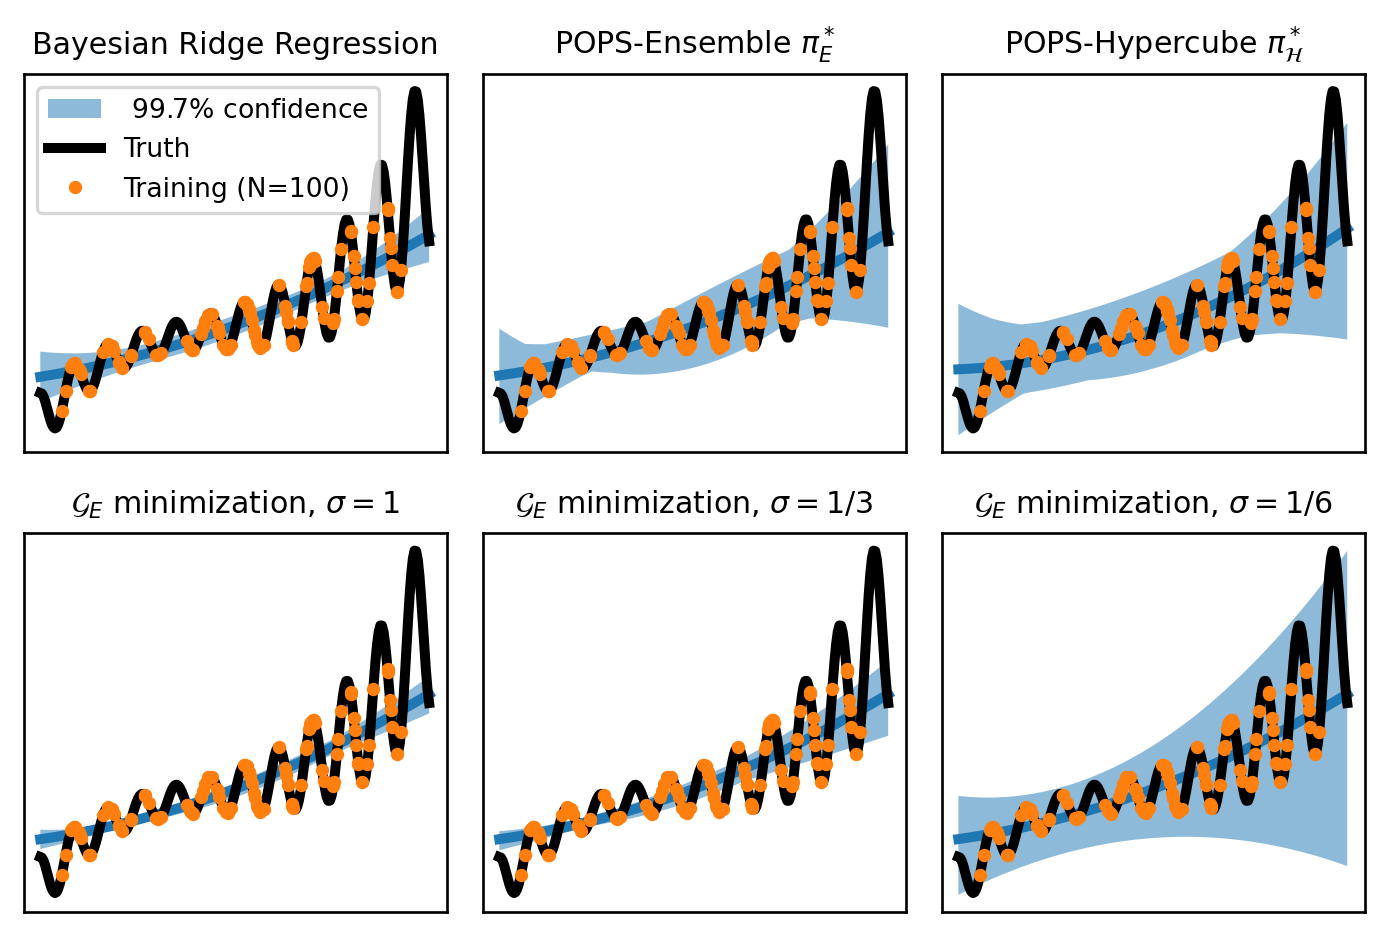

In [10]:
def plot_models(axs,models,features,ground_truth):
    
    
    axs[3].set_title(r"$\mathcal{G}_E$ minimization, $\sigma=1$",fontsize=9)
    axs[4].set_title(r"$\mathcal{G}_E$ minimization, $\sigma=1/3$",fontsize=9)
    axs[5].set_title(r"$\mathcal{G}_E$ minimization, $\sigma=1/6$",fontsize=9)
    
    for i in range(3):
        preds=test_features@optimal_models_ge[i].T
        axs[3+i].fill_between(x_dense,preds.min(1),preds.max(1),alpha=0.5,
                            label='Min-Max Range')
        axs[3+i].plot(x_dense,preds.mean(1),'C0-',lw=3,
                label='Mean')
        


    # Bayesian ridge
    axs[0].set_title("Bayesian Ridge Regression",fontsize=9)

    mu = test_features@BRR.coef_
    std = np.sqrt((test_features@BRR.sigma_ * test_features).sum(1))
    axs[0].fill_between(x_dense,mu-3.0*std,mu+3.0*std,alpha=0.5,
                        label=r' $99.7\%$ confidence')
    axs[0].plot(x_dense,mu,'C0-',lw=3,)
    
    # POPS Ensemble
    axs[1].set_title(r"POPS-Ensemble $\pi^*_E$",fontsize=9)
    preds=test_features@models.T
    axs[1].fill_between(x_dense,preds.min(1),preds.max(1),alpha=0.5,
                       label='Min-Max Range')
    axs[1].plot(x_dense,preds.mean(1),'C0-',lw=3,
             label='Mean')
    
    # POPS Hyper
    axs[2].set_title(r"POPS-Hypercube $\pi^*_\mathcal{H}$",fontsize=9)
    
    ev,v = np.linalg.eigh(models.T@models)
    v=v.T 
    print(ev.min()/ev.max())
    hc_models = np.random.uniform(  low=(models@v).min(0),
                                    high=(models@v).max(0),
                                    size=(models.shape[0],models.shape[1]))

    preds=test_features@(hc_models@v.T).T
    axs[2].fill_between(x_dense,preds.min(1),preds.max(1),alpha=0.5,
                       label='Min-Max Range')
    axs[2].plot(x_dense,preds.mean(1),'C0-',lw=3,
             label='Mean')
    
    axs[0].plot(x_dense,truth(x_dense),'k-',lw=3,label='Truth')
    axs[1].plot(x_dense,truth(x_dense),'k-',lw=3,label=None)
    axs[2].plot(x_dense,truth(x_dense),'k-',lw=3,label=None)
    axs[3].plot(x_dense,truth(x_dense),'k-',lw=3,label=None)
    axs[4].plot(x_dense,truth(x_dense),'k-',lw=3,label=None)
    axs[5].plot(x_dense,truth(x_dense),'k-',lw=3,label=None)
    
    
    axs[0].plot(training_points,ground_truth,'C1.',label=f'Training (N={training_points.size})')
    axs[1].plot(training_points,ground_truth,'C1.',label=None)
    axs[2].plot(training_points,ground_truth,'C1.',label=None)
    axs[3].plot(training_points,ground_truth,'C1.',label=None)
    axs[4].plot(training_points,ground_truth,'C1.',label=None)
    axs[5].plot(training_points,ground_truth,'C1.',label=None)
    for ax in axs:
        ax.set_xlim(-1.3,1.3)
        #ax.set_ylim(-1.2,1.2)
        ax.set_yticks([])
        ax.set_xticks([])
        #ax.legend(fontsize=8)
    axs[0].legend(fontsize=8)
    

fig,axs = plt.subplots(2,3,figsize=(6,4),sharey="row",sharex="col",dpi=240)
axs = axs.flatten()
plot_models(axs,Thetas,features,ground_truth)
plt.tight_layout()
#plt.savefig("./P3_poly_direct.png")